## Processing coral presence ground truths for soft labelling and general tasks

In [1]:
%load_ext autoreload
%autoreload 2

# spatial
import geopandas as gpd
import xarray as xa
import rasterio
from rasterio import features
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# files
import os
import sys
from pathlib import Path

# general
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# custom
from coralshift.plotting import spatial_plots
from coralshift.processing import spatial_data
from coralshift.dataloading import get_data
from coralshift.utils import config, utils
from coralshift import functions_creche

/maps/rt582/miniforge3/envs/shiftpy/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
FULL_LATS = [-32, 0]
FULL_LONS = [130, 170]

# restrict region further to visualise polygon rasterisation
LONS_LIM = [145.4, 146]
LATS_LIM = [-10.4, -9.9]

LONS_LARGE_LIM = [142, 145]
LATS_LARGE_LIM = [-13, -10]


RESOLUTION_LAT = RESOLUTION_LON = 15/3600
print(RESOLUTION_LAT)

0.004166666666666667


## UNEP-WCMC

In [11]:
# operating on remote
# load in shapefile to geopandas dataframe
# unep_fp = Path(config.gt_folder) / "unep-wcmc/01_Data/WCMC008_CoralReef2021_Py_v4_1.shp" #idk why this didn't work
# N.B. NOT /maps/rt582/coralshift/data/ground_truth/UNEP_GDCR/01_Data/WCMC008_CoralReef2021_Pt_v4_1.shp (for some reason)
unep_fp = "/maps/rt582/coralshift/data/ground_truth/UNEP_GDCR/01_Data/WCMC008_CoralReef2021_Py_v4_1.shp"
unep_gdf = gpd.read_file(unep_fp)
print(len(unep_gdf))
unep_gdf.head()

17504


,LAYER_NAME,METADATA_I,ORIG_NAME,FAMILY,GENUS,SPECIES,DATA_TYPE,START_DATE,END_DATE,DATE_TYPE,VERIF,NAME,LOC_DEF,SURVEY_MET,GIS_AREA_K,Shape_Leng,Shape_Area,REP_AREA_K,geometry
0,CRR,1.0,Not Reported,Not Reported,Not Reported,Not Reported,Not Reported,Not Reported,Not Reported,ND,Not Reported,Not Reported,Coral line buffered to 300m,Not Reported,5.059916,0.152948,0.000420,Not Reported,"POLYGON ((46.47551 -11.97419, 46.47851 -11.978..."
1,CRR,1.0,Not Reported,Not Reported,Not Reported,Not Reported,Not Reported,Not Reported,Not Reported,ND,Not Reported,Not Reported,Coral line buffered to 300m,Not Reported,5.450101,0.164919,0.000453,Not Reported,"POLYGON ((46.21811 -12.21430, 46.22181 -12.218..."
2,CRR,1.0,Not Reported,Not Reported,Not Reported,Not Reported,Not Reported,Not Reported,31/12/2009,-Y,Not Reported,Not Reported,coral,Not Reported,32.351025,1.079098,0.002664,Not Reported,"MULTIPOLYGON (((142.82287 -9.67503, 142.81353 ..."
3,CRR,1.0,Not Reported,Not Reported,Not Reported,Not Reported,Not Reported,Not Reported,Not Reported,ND,Not Reported,Not Reported,coral,Not Reported,1.823247,0.066740,0.000159,Not Reported,"POLYGON ((36.90715 21.98134, 36.89960 21.98446..."
4,CRR,1.0,Not Reported,Not Reported,Not Reported,Not Reported,Not Reported,Not Reported,Not Reported,ND,Not Reported,Not Reported,coral,Not Reported,34.815939,1.171056,0.003047,Not Reported,"MULTIPOLYGON (((36.93400 21.98049, 36.93382 21..."


(-10.4, -9.9)

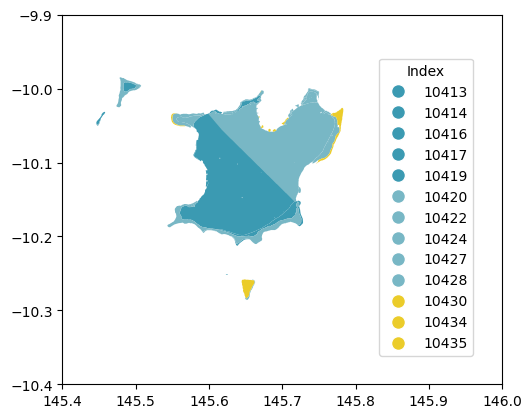

In [191]:
### visualise polygons

# limit table to GBR+ of interest.
# Often appears to plot out of range because some rows contain multiple polygons over a huge range
# Not sure what the association between these are. Satellite derivation? e.g. METADATA_I = 81.0
cs_unep_gdf = unep_gdf.cx[min(LONS_LIM)+0.9:max(LONS_LIM)-0.9, min(LATS_LIM):max(LATS_LIM)]
# plot each polygon in df a different color
colors = ["#3B9AB2", "#78B7C5", "#EBCC2A", "#E1AF00", "#d83c04"]

ax = cs_unep_gdf.geometry.plot(color=[colors[i//5] for i in range(len(cs_unep_gdf))])
# Create custom legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i // 5], markersize=10) for i in range(len(cs_unep_gdf))]
labels = [str(idx) for idx in cs_unep_gdf.index]

# Add legend to the plot
ax.legend(handles, labels, title="Index", loc="upper right", bbox_to_anchor=(0.95, 0.9))

plt.xlim(LONS_LIM)
plt.ylim(LATS_LIM)

In [ ]:
LONS_LARGE_LIM

In [9]:
LATS_LIM

[-10.4, -9.9]

In [192]:
import shapely.geometry as sgeometry
import dask_geopandas as daskgpd

lats = LATS_LARGE_LIM
lons = LONS_LARGE_LIM
resolution = 1/3600
shapefile_fp = unep_fp
gdf = daskgpd.read_file(shapefile_fp, npartitions=4)

geometry_filter = sgeometry.box(min(lons), min(lats), max(lons), max(lats))
filtered_gdf = gdf[gdf.geometry.intersects(geometry_filter)]  # coarse filter (allowing multipolys)
filtered_gdf = filtered_gdf.compute().explode(index_parts=True)
geometry_filter = sgeometry.box(min(lons), min(lats), max(lons), max(lats))
filtered_gdf = filtered_gdf[filtered_gdf.geometry.intersects(geometry_filter)]  # fine filter (all polys)
filtered_gdf.head()

# filtered_gdf.geometry.plot(
#     # color=[colors[i//5] for i in range(len(filtered_gdf))]
#     )

LAYER_NAME  METADATA_I     ORIG_NAME        FAMILY         GENUS  \
19 0        CRR         1.0  Not Reported  Not Reported  Not Reported   
   1        CRR         1.0  Not Reported  Not Reported  Not Reported   
   2        CRR         1.0  Not Reported  Not Reported  Not Reported   
   3        CRR         1.0  Not Reported  Not Reported  Not Reported   
   4        CRR         1.0  Not Reported  Not Reported  Not Reported   

           SPECIES     DATA_TYPE    START_DATE    END_DATE DATE_TYPE  \
19 0  Not Reported  Not Reported  Not Reported  31/12/2009        -Y   
   1  Not Reported  Not Reported  Not Reported  31/12/2009        -Y   
   2  Not Reported  Not Reported  Not Reported  31/12/2009        -Y   
   3  Not Reported  Not Reported  Not Reported  31/12/2009        -Y   
   4  Not Reported  Not Reported  Not Reported  31/12/2009        -Y   

             VERIF          NAME LOC_DEF    SURVEY_MET  GIS_AREA_K  \
19 0  Not Reported  Not Reported   coral  Not Reported  404.576952   
   1  Not Reported  Not Reported   coral  Not Reported  404.576952   
   2  Not Reported  Not Reported   coral  Not Reported  404.576952   
   3  Not Reported  Not Reported   coral  Not Reported  404.576952   
   4  Not Reported  Not Reported   coral  Not Reported  404.576952   

      Shape_Leng  Shape_Area    REP_AREA_K  \
19 0   12.422092    0.033349  Not Reported   
   1   12.422092    0.033349  Not Reported   
   2   12.422092    0.033349  Not Reported   
   3   12.422092    0.033349  Not Reported   
   4   12.422092    0.033349  Not Reported   

                                               geometry  
19 0  POLYGON ((143.52452 -10.25341, 143.52591 -10.2...  
   1  POLYGON ((143.70993 -10.25257, 143.71000 -10.2...  
   2  POLYGON ((142.84944 -10.24793, 142.84959 -10.2...  
   3  POLYGON ((143.20847 -10.19759, 143.21028 -10.2...  
   4  POLYGON ((142.82928 -10.19495, 142.83820 -10.1...

In [156]:
filtered_gdf.GIS_AREA_K.unique()

array([  7.21553123,   2.8573731 ,   0.39700011, 173.65748539,
        11.96656008,   5.35033307, 156.74974803,  50.94498431,
        19.38519517,   0.25027854,   9.6577823 ,   0.79192092,
        50.28439141])

<Axes: >

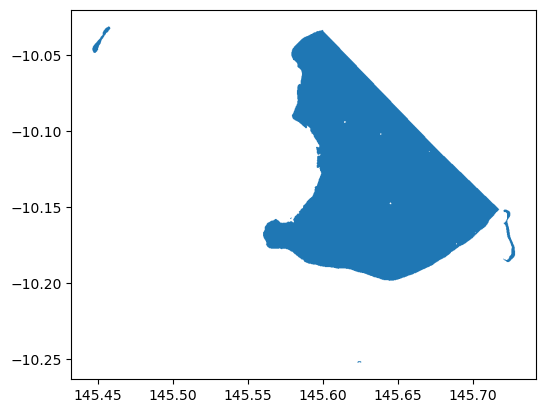

In [184]:
# select rows with maximum GIS_AREA_K
max_area_gdf = filtered_gdf.sort_values("GIS_AREA_K", ascending=False)
# select first value of first column of multiindex
max_area_gdf.loc[max_area_gdf.GIS_AREA_K == max_area_gdf.GIS_AREA_K.max()].plot()


In [180]:
filtered_gdf.GIS_AREA_K.max()

173.657485392

In [153]:
[print(col, filtered_gdf[col].nunique()) for col in filtered_gdf.columns]

LAYER_NAME 1
METADATA_I 1
ORIG_NAME 1
FAMILY 1
GENUS 1
SPECIES 1
DATA_TYPE 1
START_DATE 1
END_DATE 1
DATE_TYPE 1
VERIF 1
NAME 1
LOC_DEF 13
SURVEY_MET 1
GIS_AREA_K 13
Shape_Leng 13
Shape_Area 13
REP_AREA_K 1
geometry 53


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

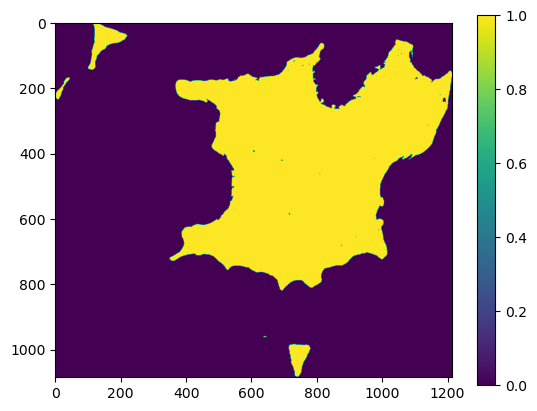

In [125]:
raster = get_data.rasterize_geodf(filtered_gdf, resolution=resolution)
plt.imshow(raster)
plt.colorbar()

In [33]:
# send xarray dataarray to dataset
    

In [40]:
from coralshift.utils.config import Config
from coralshift.utils import file_ops

config_fp = "/maps/rt582/coralshift/runs/config_files/config_test.yaml"
config_info = file_ops.read_yaml(config_fp)
config = Config(config_info)

In [45]:
import rioxarray

out_raw = get_data.ReturnRaster(config, resolution=15/3600, lons=LONS_LIM, lats=LATS_LIM).return_raster('unep')

Loading UNEP_GDCR data from original shapefile: /maps-priv/maps/rt582/coralshift/data/ground_truth/UNEP_GDCR/01_Data/WCMC008_CoralReef2021_Py_v4_1.shp
generating UNEP raster at 0.004 degrees resolution...
casting raster to xarray...
saving UNEP raster to /maps-priv/maps/rt582/coralshift/data/ground_truth/UNEP_GDCR/rasters/unep_0-004_S11-4_S8-9_E144-4_E147-0.nc...
	applying spatial buffering...
1 raster(s) to spatially buffer...


Buffering variables: 100%|██████████| 1/1 [00:00<00:00, 21.44it/s]


	resampling dataset to 0.004166666666666667 degree(s) resolution...

Resampling pipeline: written raster CRS to EPSG:4326


In [59]:
resolution

0.0002777777777777778

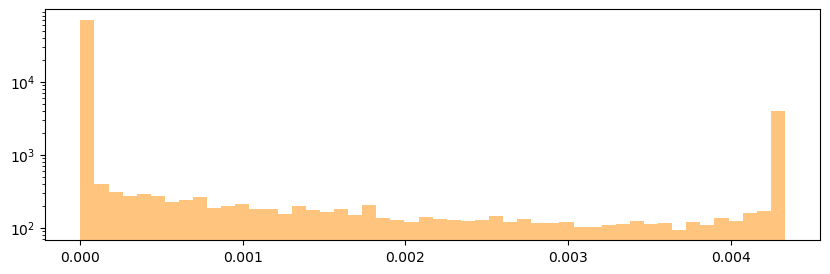

In [202]:
resolution = 15/3600
raster_15 = get_data.rasterize_geodf(filtered_gdf, resolution=resolution)
xa_d_15 = get_data.raster_to_xarray(
    raster_15,
    x_y_limits=utils.lat_lon_vals_from_geo_df(filtered_gdf)[:4],
    resolution=resolution,
    name='UNEP_GDCR'.upper(),
).chunk("auto")
xa_d_15.longitude.attrs["units"] = "degrees_east"  # not tested
xa_d_15.latitude.attrs["units"] = "degrees_north"  # not tested
# ds = xa_d_15.to_dataset(name="UNEP_GDCR")
# write crs to dataset
xa_d_15.rio.write_crs(rasterio.crs.CRS.from_epsg(4326), inplace=True)

from rasterio.enums import Resampling

resample_method = Resampling.sum
xa_d_15_resampled = get_data.rio_absolute_resample(
    # raster.sel(latitude=slice(*LATS), longitude=slice(*LONS)),
    xa_d_15,
    lat_resolution=0.01,
    lon_resolution=0.01,
    lat_range=lats,
    lon_range=lons,
    resample_method=resample_method,
    project_first=True,
)

lat_res, lon_res = abs(xa_d_15_resampled.rio.resolution()[0]), abs(xa_d_15_resampled.rio.resolution()[1])
cell_area = lat_res * lon_res   # in degrees
cell_area = cell_area * 110e3**2 * np.cos(np.mean(xa_d_15_resampled.sel(latitude=slice(*lat_lims), longitude=slice(*lon_lims)).latitude) * np.pi / 180)  # in m^2

# number of 30x30m cells in cell
num_30 = cell_area / 30**2
# coverage density
xa_d_15_resampled_density = xa_d_15_resampled / num_30


f, ax = plt.subplots(1, 1, figsize=(10, 3))
plt.hist(xa_d_15_resampled_density.values.flatten(), bins=50, color="darkorange", alpha=0.5, label='15" raster')
# plt.hist(test.values.flatten(), bins=50, color="blue", alpha=0.5, label='1" raster')
# plt.legend()
plt.yscale("log")

In [203]:
resolution = 1/3600
raster_1 = get_data.rasterize_geodf(filtered_gdf, resolution=resolution)
xa_d_1 = get_data.raster_to_xarray(
    raster_1,
    x_y_limits=utils.lat_lon_vals_from_geo_df(filtered_gdf)[:4],
    resolution=resolution,
    name='UNEP_GDCR'.upper(),
).chunk("auto")
xa_d_1.longitude.attrs["units"] = "degrees_east"  # not tested
xa_d_1.latitude.attrs["units"] = "degrees_north"  # not tested
# ds = xa_d_1.to_dataset(name="UNEP_GDCR")
# write crs to dataset
xa_d_1.rio.write_crs(rasterio.crs.CRS.from_epsg(4326), inplace=True)

from rasterio.enums import Resampling

resample_method = Resampling.sum
xa_d_1_resampled = get_data.rio_absolute_resample(
    # raster.sel(latitude=slice(*LATS), longitude=slice(*LONS)),
    xa_d_1,
    lat_resolution=0.01,
    lon_resolution=0.01,
    lat_range=lats,
    lon_range=lons,
    resample_method=resample_method,
    project_first=True,
)

lat_res, lon_res = abs(xa_d_1_resampled.rio.resolution()[0]), abs(xa_d_1_resampled.rio.resolution()[1])
cell_area = lat_res * lon_res   # in degrees
cell_area = cell_area * 110e3**2 * np.cos(np.mean(xa_d_1_resampled.sel(latitude=slice(*lat_lims), longitude=slice(*lon_lims)).latitude) * np.pi / 180)  # in m^2

# number of 30x30m cells in cell
num_30 = cell_area / 30**2
# coverage density
xa_d_1_resampled_density = xa_d_1_resampled / num_30

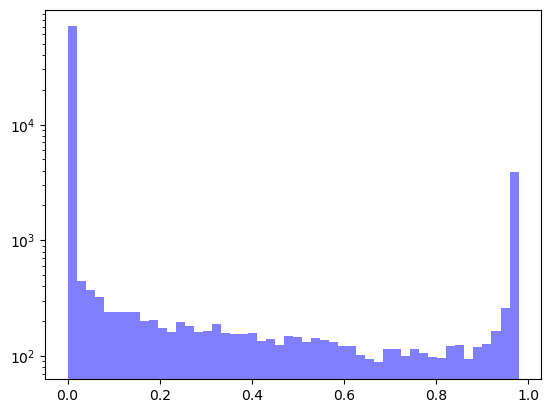

In [204]:
# f, ax = plt.subplots(1, 1, figsize=(10, 3))
# plt.hist(xa_d_1_resampled_density.values.flatten(), bins=50, color="darkorange", alpha=0.5, label='15" raster')
plt.hist(xa_d_1_resampled_density.values.flatten(), bins=50, color="blue", alpha=0.5, label='1" raster')
# plt.legend()
plt.yscale("log")

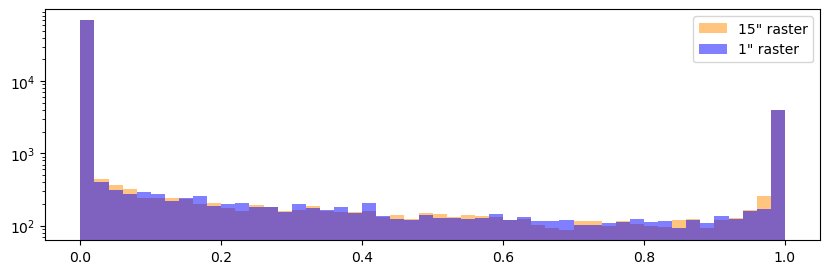

In [211]:
# minmax normalise
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
xa_d_15_resampled_density_norm = xa_d_15_resampled_density.copy()
xa_d_15_resampled_density_norm_values = scaler.fit_transform(xa_d_15_resampled_density_norm.values.reshape(-1, 1))
xa_d_1_resampled_density_norm = xa_d_1_resampled_density.copy()
xa_d_1_resampled_density_norm_values = scaler.fit_transform(xa_d_1_resampled_density_norm.values.reshape(-1, 1))

f, ax = plt.subplots(1, 1, figsize=(10, 3))
plt.hist(xa_d_1_resampled_density_norm_values.flatten(), bins=50, color="darkorange", alpha=0.5, label='15" raster')
plt.hist(xa_d_15_resampled_density_norm_values.flatten(), bins=50, color="blue", alpha=0.5, label='1" raster')
plt.legend()
plt.yscale("log")

In [206]:
xa_d_15_resampled_density_norm

<xarray.DataArray (latitude: 301, longitude: 301)> Size: 725kB
array([[ 0.,  0.,  0., ..., nan, nan, nan],
       [ 0.,  0.,  0., ..., nan, nan, nan],
       [ 0.,  0.,  0., ..., nan, nan, nan],
       ...,
       [ 0.,  0.,  0., ..., nan, nan, nan],
       [ 0.,  0.,  0., ..., nan, nan, nan],
       [ 0.,  0.,  0., ..., nan, nan, nan]])
Coordinates:
  * longitude    (longitude) float64 2kB 142.0 142.0 142.0 ... 145.0 145.0 145.0
  * latitude     (latitude) float64 2kB -13.0 -12.99 -12.98 ... -10.01 -10.0
    spatial_ref  int64 8B 0

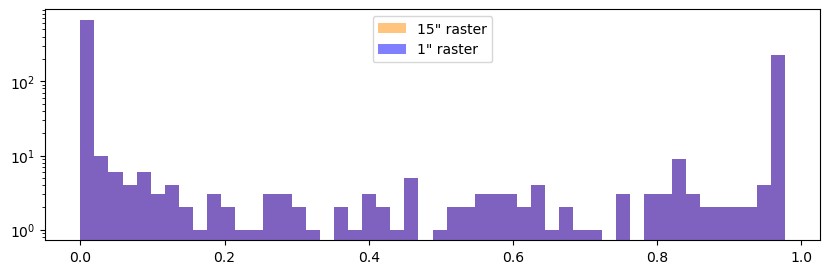

In [198]:
f, ax = plt.subplots(1, 1, figsize=(10, 3))
plt.hist(xa_d_15_resampled_density.values.flatten(), bins=50, color="darkorange", alpha=0.5, label='15" raster')
plt.hist(xa_d_1_resampled_density.values.flatten(), bins=50, color="blue", alpha=0.5, label='1" raster')
plt.legend()
plt.yscale("log")

In [201]:
np.nanmax(xa_d_15_resampled_density)

0.9768737771995262

In [126]:
xa_d = get_data.raster_to_xarray(
    raster,
    x_y_limits=utils.lat_lon_vals_from_geo_df(filtered_gdf)[:4],
    resolution=resolution,
    name='UNEP_GDCR'.upper(),
).chunk("auto")
xa_d.longitude.attrs["units"] = "degrees_east"  # not tested
xa_d.latitude.attrs["units"] = "degrees_north"  # not tested
# ds = xa_d.to_dataset(name="UNEP_GDCR")
# write crs to dataset
xa_d.rio.write_crs(rasterio.crs.CRS.from_epsg(4326), inplace=True)

from rasterio.enums import Resampling

resample_method = Resampling.sum
xa_d_resampled = get_data.rio_absolute_resample(
    # raster.sel(latitude=slice(*LATS), longitude=slice(*LONS)),
    xa_d,
    lat_resolution=0.01,
    lon_resolution=0.01,
    lat_range=lats,
    lon_range=lons,
    resample_method=resample_method,
    project_first=True,
)

In [127]:
# get minmax lat/lon values from xa_d
lat_lims = utils.get_min_max_coords(xa_d, 'latitude')
lon_lims = utils.get_min_max_coords(xa_d, 'longitude')

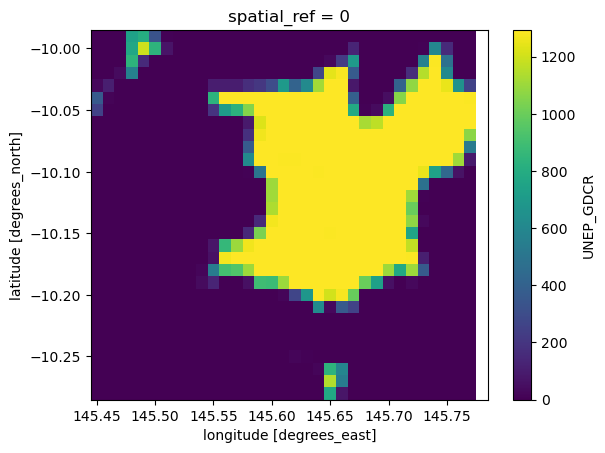

In [128]:
xa_d_resampled.sel(latitude=slice(*lat_lims), longitude=slice(*lon_lims)).plot()

In [121]:
np.nanmax(xa_d_resampled.values)

5.515011887597978

In [130]:
xa_d_resampled

<xarray.DataArray 'UNEP_GDCR' (latitude: 51, longitude: 61)> Size: 25kB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * longitude    (longitude) float64 488B 145.4 145.4 145.4 ... 146.0 146.0
  * latitude     (latitude) float64 408B -10.4 -10.39 -10.38 ... -9.91 -9.9
    spatial_ref  int64 8B 0
Attributes:
    _FillValue:  1.7976931348623157e+308

In [133]:
lat_res, lon_res = abs(xa_d_resampled.rio.resolution()[0]), abs(xa_d_resampled.rio.resolution()[1])
cell_area = lat_res * lon_res   # in degrees
cell_area = cell_area * 110e3**2 * np.cos(np.mean(xa_d_resampled.sel(latitude=slice(*lat_lims), longitude=slice(*lon_lims)).latitude) * np.pi / 180)  # in m^2

# number of 30x30m cells in cell
num_30 = cell_area / 30**2
# coverage density
test = xa_d_resampled / num_30
print(np.nanmax(test.values))

0.9768737771995262


In [110]:
5.5 / num_30

<xarray.DataArray 'latitude' ()> Size: 8B
array(0.00415595)
Coordinates:
    spatial_ref  int64 8B 0

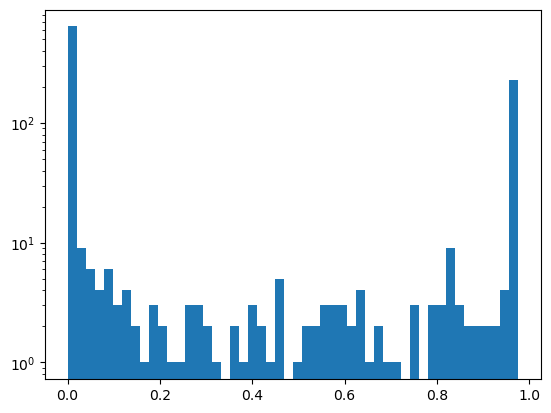

In [137]:
plt.hist(test.sel(latitude=slice(*lat_lims), longitude=slice(*lon_lims)).values.flatten(), bins=50)
plt.yscale('log')

In [20]:
xa_d = get_data.raster_to_xarray(
    raster,
    x_y_limits=utils.lat_lon_vals_from_geo_df(filtered_gdf)[:4],
    resolution=resolution,
    name='UNEP_GDCR'.upper(),
).chunk("auto")
xa_d.longitude.attrs["units"] = "degrees_east"  # not tested
xa_d.latitude.attrs["units"] = "degrees_north"  # not tested

In [ ]:
cs_unep_gdf.geometry.iloc[12]

In [ ]:
# rasterise area
cs_unep_raster = get_data.rasterize_geodf(cs_unep_gdf, resolution=RESOLUTION_LAT)
cs_unep_raster_xa = get_data.raster_to_xarray(
    cs_unep_raster, x_y_limits=get_data.lat_lon_vals_from_geo_df(cs_unep_gdf)[:4], 
    resolution=RESOLUTION_LAT)

In [ ]:
def shapely_to_linear_ring(shapely_geom):
    """
    Convert Shapely geometry to LinearRing or list of LinearRings for Polygon/MultiPolygon.
    """
    if isinstance(shapely_geom, sg.Polygon):
        return [sg.LinearRing(list(shapely_geom.exterior.coords))]
    elif isinstance(shapely_geom, sg.MultiPolygon):
        return [sg.LinearRing(list(poly.exterior.coords)) for poly in shapely_geom.geoms]
    else:
        raise ValueError("Unsupported geometry type")

In [ ]:
import shapely.geometry as sg
# xx, yy = cs_unep_gdf.iloc[4].geometry.exterior.coords.xy
# xs = xx.tolist()
# ys = yy.tolist()
# sg.LinearRing([(x, y) for x, y in zip(xs, ys)])

# fig = plt.figure(figsize=(10, 10))

# gs = fig.add_gridspec(1, 2)
# ax_poly = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree())
# ax_raster = fig.add_subplot(gs[0,1], projection=ccrs.PlateCarree()) # check unep projection

# # plot native polygon
# # cs_unep_gdf.iloc[:].geometry.plot(ax=ax_poly)

# # ax_poly.add_feature(cfeature.COASTLINE.with_scale('110m'), linewidth=0.75)
# # ax_poly.add_geometries(cs_unep_gdf.iloc[:].geometry, crs=ccrs.PlateCarree())
# ax_poly.add_geometries([sg.LinearRing(cs_unep_gdf.iloc[4].geometry.exterior.coords)], crs=ccrs.PlateCarree())
# # spatial_plots.format_spatial_plot()

# # ax_poly.set_xlim(min(tight_area_lons), max(tight_area_lons))
# # ax_poly.set_ylim(min(tight_area_lats), max(tight_area_lats))
# ax_poly.set_xlim(min(xs), max(xs))
# ax_poly.set_ylim(min(ys), max(ys))
# # spatial_plots.plot_spatial(cs_unep_raster_xa, fax=(fig,ax_raster), cbar=False)

# for ax in [ax_poly, ax_raster]:
#     ax.set_xlim(min(tight_area_lons), max(tight_area_lons))
#     ax.set_ylim(min(tight_area_lats), max(tight_area_lats))

# ax_poly.set_title("Native polygon format")
# ax_raster.set_title("Rasterised")



# TODO: plot linear rings on rasters
# shapely_to_linear_ring(cs_unep_gdf.iloc[4].geometry)
sg.LinearRing(cs_unep_gdf.iloc[3].geometry.exterior.coords)

In [ ]:
unep_gdf.geometry.iloc[7]

In [ ]:
# resolution_lon, resolution_lat = 1, 1

# return df of only the reefs in the area within the bounds of full_lats and full_lons
unep_raster = get_data.rasterize_geodf(unep_gdf, resolution=RESOLUTION_LAT)
# normalise raster. Normalise to what value? Will be done eventually in ml preprocess, but interesting question
unep_norm_raster = unep_raster / unep_raster.max()

plt.imshow(unep_raster[1050:1150, 950:1050])
plt.colorbar()

In [ ]:
plt.imshow(unep_raster)

In [ ]:
xa_unep = get_data.raster_to_xarray(
    unep_norm_raster, x_y_limits=get_data.lat_lon_vals_from_geo_df(unep_gdf)[:4], 
    resolution=RESOLUTION_LAT)
# Plot the xarray DataArray
xa_unep.sel(latitude=slice(min(LATS_LIM), max(LATS_LIM)), longitude=slice(min(LONS_LIM), max(LONS_LIM))).plot()

In [ ]:
xa.open_dataset(gebco_fp)

In [ ]:
gebco_fp = (
    Path(config.bathymetry_dir) / "gebco/gebco_2023_n0.0_s40.0_e130.0_e170.0.nc"
)
gebco_xa = spatial_data.process_xa_d(xa.open_dataset(gebco_fp))
gebco_xa.latitude.values[:5]

In [ ]:
# depth limits
depth_lims = [-50, 20]

# generate limited and remove nan coloration
xa_unep.sel(latitude=slice(min(LATS_LIM),max(LATS_LIM)),longitude=slice(min(LONS_LIM),max(LONS_LIM)))
xa_unep_lim = xa_unep.sel(latitude=slice(min(LATS_LIM),max(LATS_LIM)),longitude=slice(min(LONS_LIM),max(LONS_LIM)))
nan_xa_unep = xa_unep.where(xa_unep != 0, np.nan)

# mask gebco and create limited version
shallow_masked_gebco = gebco_xa["elevation"].where((gebco_xa["elevation"] < max(depth_lims)) & (gebco_xa["elevation"] > min(depth_lims)), np.nan)
gebco_xa_lim = shallow_masked_gebco.sel(latitude=slice(min(LATS_LIM),max(LATS_LIM)),longitude=slice(min(LONS_LIM),max(LONS_LIM)))

# gbr_xa_unep = xa_unep.sel(latitude=slice(min(LATS_LIM),max(LATS_LIM)),longitude=slice(min(LONS_LIM),max(LONS_LIM)))
gbr_norm_nan_xa_unep = (xa_unep / np.nanmax(xa_unep)).where(xa_unep != 0, np.nan)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection=ccrs.PlateCarree()))

spatial_plots.plot_spatial(
    shallow_masked_gebco.sel(latitude=slice(min(LATS_LARGE_LIM),max(LATS_LARGE_LIM)),longitude=slice(min(LONS_LARGE_LIM),max(LONS_LARGE_LIM))), 
    title=None, cbar_dict={'cbar': False}, fax=(fig, ax), alpha=0.3)

spatial_plots.plot_spatial(
    gbr_norm_nan_xa_unep.sel(latitude=slice(min(LATS_LARGE_LIM),max(LATS_LARGE_LIM)),longitude=slice(min(LONS_LARGE_LIM),max(LONS_LARGE_LIM))), 
    title="Rasterised UNEP Reef Presence", cbar_dict={'cbar': False}, fax=(fig, ax),
    alpha=0.5)

In [ ]:
plt.hist(gbr_norm_nan_xa_unep.sel(longitude=slice(min(LONS_LIM), max(LONS_LIM)), latitude=slice(min(LATS_LIM), max(LATS_LIM))).values, bins=np.linspace(0,1,50));
plt.yscale('log')
plt.xlim(0.9,1)

In [ ]:
gbr_norm_nan_xa_unep

In [ ]:
get_data.

In [ ]:
RESOLUTION_LAT

In [ ]:
# resample to 1/4 degree
resampled = get_data.rio_absolute_resample(
    gbr_norm_nan_xa_unep,
    lat_resolution=RESOLUTION_LAT,
    lon_resolution=RESOLUTION_LAT,
    lat_range=(min(LATS_LARGE_LIM), max(LATS_LARGE_LIM)),
    lon_range=(min(LONS_LARGE_LIM), max(LONS_LARGE_LIM)),
)

In [ ]:
config_fp
# get_data

In [ ]:
np.nanmax(resampled.values)

In [ ]:
vals = resampled.sel(longitude=slice(min(LONS_LARGE_LIM), max(LONS_LARGE_LIM)), latitude=slice(min(LATS_LARGE_LIM), max(LATS_LARGE_LIM)))

In [ ]:
plt.hist(resampled.sel(longitude=slice(min(LONS_LARGE_LIM), max(LONS_LARGE_LIM)), latitude=slice(min(LATS_LARGE_LIM), max(LATS_LARGE_LIM))).values, bins=np.linspace(0,1,50));
plt.yscale('log')
# plt.xlim(0.9,1)

In [ ]:
spatial_plots.plot_spatial(
    xa_unep, title="Rasterised UNEP Reef Presence", orient_colorbar="horizontal", presentation=True, map_proj=ccrs.Robinson())

## Reef Check 

In [ ]:
# load in substrate. Will need to change data location. Can I use a URL?
# check out environment consistencies: want to use mamba and delete others

# this could be useful: https://annefou.github.io/metos_python/04-plotting/

# read in spreadsheet.
# DATES NOT PARSING PROPERLY
substrate_csv = pd.read_csv("data/ground_truth/reef_check/Substrate.csv.crdownload",
    parse_dates=["date"], 
    # date_format="%d-%B-%y"
    )

substrate_csv.head()

In [ ]:
substrate_csv.columns

In [ ]:
# make working copy: not sure how necessary this is
df_substrate = substrate_csv

In [ ]:
substrate_csv.total.iloc[0]

# some entries in "total" column are "O" rather than "0"!
df_substrate.total.replace("O", "0")
df_substrate["total"] = pd.to_numeric(df_substrate['total'], errors='coerce').fillna(0).astype('int64')


In [ ]:
# would a function be necessary here? When are they necessary for such specific data processing tasks???

# make working copy: not sure how necessary this is
df_substrate = substrate_csv
# df_substrate.date = pd.to_datetime(df_substrate.date, format="%d-%B-%y")

# Split the column on the comma
split_series = df_substrate["coordinates_in_decimal_degree_format"].str.split(',')

# strip any leading/trailing spaces
split_series = split_series.apply(lambda x: [(val.strip()) for val in x])

# convert to float if possible
out = split_series[:].apply(lambda x: [functions_creche.try_convert_to_float(val.strip()) for val in x])

# write to separate columns in df
df_substrate[["lat_decimal", "lon_decimal"]] = pd.DataFrame(out.to_list(), index=df_substrate.index)

In [ ]:
# nans aren't the same
print("lon_decimal nans:", sum(df_substrate["lon_decimal"].isna()))
print("lat_decimal nans:", sum(df_substrate["lat_decimal"].isna()))

# remove all rows containing a nan in either of these two columns
df_substrate_processed = df_substrate.dropna(subset=["lon_decimal", "lat_decimal"])

In [ ]:
df_substrate_processed.date

In [ ]:
# limit df to lats/lons of interest
df_substrate_gbr = df_substrate_processed[
    df_substrate_processed.lon_decimal.between(142,159) & df_substrate_processed.lat_decimal.between(-27,-10)
    ]

import geopandas as gpd
from matplotlib.dates import date2num
import matplotlib.pyplot as plt


# initialize an axis
fig, ax = plt.subplots(figsize=(8,6))
# plot map on axis
countries = gpd.read_file(  
     gpd.datasets.get_path("naturalearth_lowres"))
# countries[countries["name"] == "Australia"].plot(color="lightgrey",
#                                                  ax=ax)
countries.plot(color="lightgrey",ax=ax)
# plot points
df_substrate_gbr.plot(x="lon_decimal", y="lat_decimal", kind="scatter", c=(df_substrate_gbr['year']),
    colormap="Oranges", title="Reef Check Coral Surveys", ax=ax)

ax.set_xlim([140,160])
ax.set_ylim([-30,-10])

ax.grid(alpha=0.5)
plt.show()

In [ ]:
df = df_substrate_gbr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

fig = plt.figure(figsize=[10,10])
ax = plt.axes(projection=ccrs.PlateCarree())

# plot as points
ax.add_feature(
    cfeature.NaturalEarthFeature(
        "physical", "land", "10m", edgecolor="k", facecolor="#d2ccc4"
    )
)
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)

first_month = df["date"].min().strftime("%b %Y")
last_month = df["date"].max().strftime("%b %Y")


df.plot(x="lon_decimal", y="lat_decimal", kind="scatter", s=5, c=df["total"], cmap="Oranges",
        title="Reef Check Coral Surveys", ax=ax)

In [ ]:
substrate_raster = functions_creche.rasterise_points_df(
    df_substrate_gbr, "lat_decimal", "lon_decimal", resolution_lat=resolution_lat, resolution_lon=resolution_lon)
substrate_xarray = functions_creche.raster_to_xarray(
    substrate_raster, resolution_lat=resolution_lat, resolution_lon=resolution_lon, x_y_limits=[-180,-90,180,90])

spatial_plots.plot_spatial(
    substrate_xarray.sel(latitude=slice(min(full_lats),max(full_lats)), longitude=slice(min(full_lons),max(full_lons))),
    title="Rasterised Reef Check coral presence survey data", orient_colorbar="horizontal", presentation=True)

In [ ]:
substrate_xarray

## Allen Coral Atlas

In [ ]:
# read in ACA GBR gpkg file
# aca_gbr = gpd.read_file("lustre_scratch/datasets/ground_truths/allen_coral_atlas/GBR/Benthic-Map/benthic.gpkg")

import dask_geopandas
import geopandas as gpd
import pandas as pd
from coralshift.dataloading import config
from coralshift import functions_creche
import dask

benthic_fps = [Path(config.gt_folder) / "allen_coral_atlas/GBR_TS/Benthic-Map/benthic.gpkg",
    Path(config.gt_folder) / "allen_coral_atlas/EPNG/Benthic-Map/benthic.gpkg",
    Path(config.gt_folder) / "allen_coral_atlas/misc/Benthic-Map/benthic.gpkg",
]
# input_geopackages = [Path("allen_coral_atlas/GBR/Benthic-Map/benthic.gpkg")]

benthic_dfs = []
for benthic_fp in benthic_fps:
    dask_gpd = dask_geopandas.read_file(benthic_fp, npartitions=4)
    # select coral
    gpd_coral = dask_gpd[dask_gpd["class"] == "Coral/Algae"]
    benthic_dfs.append(gpd_coral)

aca_coral = dask.dataframe.multi.concat(benthic_dfs)


In [ ]:
# lon_resolution, lat_resolution = 0.1, 0.1
# this can take a while
aca_coral_raster = functions_creche.rasterize_geodf(aca_coral, resolution_lat=resolution_lat, resolution_lon=resolution_lon)
aca_norm_raster = aca_coral_raster / aca_coral_raster.max()

In [ ]:
plt.imshow(aca_coral_raster[:1000,:1000])
plt.colorbar()

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 7))

normal_ax = ax[0].imshow(aca_coral_raster[:1000,:1000])
log_ax = ax[1].imshow(aca_coral_raster[:1000,:1000], norm="log")
plt.colorbar(normal_ax, ax=ax[0], fraction=0.05)
plt.colorbar(log_ax, ax=ax[1], fraction=0.05)
plt.suptitle("Additive coral raster")


fig, ax = plt.subplots(ncols=2, figsize=(15, 7))

normal_ax = ax[0].imshow(aca_norm_raster[:1000,:1000])
log_ax = ax[1].imshow(aca_norm_raster[:1000,:1000], norm="log")
plt.colorbar(normal_ax, ax=ax[0], fraction=0.05)
plt.colorbar(log_ax, ax=ax[1], fraction=0.05)
plt.suptitle("Normalised coral raster")


# ax[0].colorbar()
# ax[1].colorbar()

In [ ]:
plt.hist(aca_norm_raster.flatten(), 100)
plt.yscale("log")

In [ ]:
aca_coral_bounds = functions_creche.lat_lon_vals_from_geo_df(aca_coral.compute())
xa_aca = spatial_data.process_xa_d(
    functions_creche.raster_to_xarray(aca_norm_raster, aca_coral_bounds[:4], resolution_lat=resolution_lat, resolution_lon=resolution_lon))

In [ ]:
xa_aca

In [ ]:
lat_sel = [-15,-14.85]
lon_sel = [159.4,159.55]


spatial_plots.plot_spatial(
    xa_aca.sel(latitude=slice(min(lat_sel),max(lat_sel)), longitude=slice(min(lon_sel),max(lon_sel))))

In [ ]:
spatial_plots.plot_spatial(xa_aca, title=f"Rasterised ACA Coral/Algae\nat {lat_resolution} degree resolution")

## XL Catlin

In [ ]:
# load in spreadsheet
catlin_atl_csv_p = Path(config.gt_folder) / "xl_catlin/seaviewsurvey_reefcover_atlantic.csv"
catlin_atl_df = pd.read_csv(catlin_atl_csv_p)
catlin_atl_df.head()

In [ ]:
# TODO: use regional classifications
# for each region, determine which class labels correspond to coral: "Hard Coral" and "Soft Coral"

# load in class label info
catlin_labels_csv_p = Path("xl_catlin/seaviewsurvey_labelsets.csv")
catlin_labels_df = pd.read_csv(catlin_labels_csv_p)

coral_func_groups = ["Hard Coral", "Soft Coral"]

coral_labels_df = catlin_labels_df[catlin_labels_df["func_group"].isin(coral_func_groups)]
coral_labels = coral_labels_df["label"].to_list()


In [ ]:
# collate necessary survey files

dir_path = Path("xl_catlin")
reefcover_csvs = list(dir_path.glob("**/*reefcover*.csv"))

dfs = []
for csv in reefcover_csvs:
    reefcover_df = pd.read_csv(csv)
    dfs.append(reefcover_df)

reefcover_df = pd.concat(dfs, ignore_index=True)
meta_columns = reefcover_df.columns[:5].tolist()
catlin_coral_df = reefcover_df[meta_columns + coral_labels]

# sum all coral columns in each row, ignoring first five columns
catlin_coral_df["total_coral"] = catlin_coral_df.iloc[:, 5:].sum(axis=1)

catlin_coral_df.head()

In [ ]:
# this is incredibly fast – rasterising points much quicker than polygons
lat_resolution, lon_resolution = 0.001, 0.001

# cast to raster
catlin_coral_raster = rasterise_points_df(
    catlin_coral_df, "lat", "lng", lat_resolution=lat_resolution, lon_resolution=lon_resolution)
# convert raster to xarray
catlin_coral_xa = raster_to_xarray(
    catlin_coral_raster, lat_resolution=lat_resolution, lon_resolution=lon_resolution, x_y_limits=[-180, -90, 180, 90])

In [ ]:
catlin_coral_xa

In [ ]:
# cast to raster
catlin_coral_raster_lowres = rasterise_points_df(
    catlin_coral_df, "lat", "lng", lat_resolution=0.1, lon_resolution=0.1)
# convert raster to xarray
catlin_coral_xa_lowres = raster_to_xarray(
    catlin_coral_raster_lowres, lat_resolution=0.1, lon_resolution=0.1, x_y_limits=[-180, -90, 180, 90])
spatial_plots.plot_spatial(catlin_coral_xa_lowres.sel(latitude=slice(-10,-30), longitude=slice(140,160)), title="Rasterised Catlin Coral Cover Lowres")


In [ ]:
spatial_plots.plot_spatial(catlin_coral_xa.sel(latitude=slice(-15.38,-15.4), longitude=slice(145.78,145.8)), title="Rasterised Catlin Coral Cover")
# ax.set_xlim([140,150])
# ax.set_ylim([-30,0])

## Generate ground truth comparisons for presentation


In [ ]:
# declare region
lat_sel = [-20, -19]
lon_sel = [148, 150]

In [ ]:
spatial_plots.plot_spatial(
    substrate_xarray.sel(latitude=slice(min(lat_sel),max(lat_sel)), longitude=slice(min(lon_sel),max(lon_sel))), presentation=True)

In [ ]:
spatial_plots.plot_spatial(
    xa_aca.sel(latitude=slice(min(lat_sel),max(lat_sel)), longitude=slice(min(lon_sel),max(lon_sel))),
    presentation=True)

In [ ]:
xa_unep

In [ ]:
spatial_plots.plot_spatial(
    xa_unep.sel(latitude=slice(min(lat_sel),max(lat_sel)), longitude=slice(min(lon_sel),max(lon_sel))),
    presentation=True)

In [ ]:
spatial_plots.plot_spatial(
    catlin_coral_xa.sel(latitude=slice(min(lat_sel),max(lat_sel)), longitude=slice(min(lon_sel),max(lon_sel))),
    presentation=True)

### Graveyard

In [ ]:
# from rasterio import features
# out = features.rasterize(geom[:], out_shape=(40, 180), all_touched=True, merge_alg=features.MergeAlg.replace, transform=rasterio.Affine(0.1, 0, 0, 0, -0.1, 0))
# plt.imshow(out)

###

# from geocube.api.core import make_geocube
# import rasterio as rio

# # must be a better way to organise this!!
# input_gpkg_p = Path("allen_coral_atlas/GBR/Benthic-Map/benthic.gpkg")

# out_grid = make_geocube(
#     vector_data=input_gpkg_p,
#     resolution=(-1, 1),
# )